# M5 Competition

## Introduction

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/last-release/docs/src/tutorials/m5_competition.ipynb)

The M5 Competition, held in 2020, was part of the prestigious Makridakis Forecasting Competitions. The goal of this competition was to accurately forecast the sales of 3,000 individual items across 10 Walmart stores for the next 28 days. The winning strategy involved transforming and augmenting the raw multivariate time series data into a tabular dataset, which was then used to train a collection of Gradient Boosted Trees models.

See https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview.

In this notebook, we show how Temporian can replicate such data preprocessing and feature engineering with low effort. More specifically, we will replicate, with much less code, the preprocessing demonstrated at the [Khipu 2023: A Hands-On Forecasting Guide](https://colab.sandbox.google.com/drive/1nJ7GP0kayoCt6J-QkhyJw8jvr5uLnLcy), which was done with Pandas.

The notebook is divided into three parts:

- Loading the dataset and initial cleaning using Pandas.
- Temporal feature engineering using Temporian.
- Training and evaluation of a model using TensorFlow Decision Forests.

The following preprocessing operations will be applied using Temporian:

- **label**: Compute forecasting labels i.e. future leak of sales data.
- **lagged sales**: Give access to previous sales data.
- **moving statistics**: Moving average, sum and standard deviation of the sales over the last 7, 14, 28 and 64 days.
- **calendar features**: Extract discriminative calendar features such as day of the week, day of the month, etc.
- **aggregated sales**: Aggregate sales per department. Each item has access to the sales of its corresponding department.
- **special events**: Holidays, sales, and other special events.
- **train / test split**: Split the data between a training and testing dataset.

## Install and import dependencies


In [1]:
%pip install temporian -q

# The Bokeh package is used by Temporian to create interactive plots.
# If if Bokeh is not installed, Temporian plots are static.
%pip install bokeh -q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import urllib.request
import zipfile
from collections import defaultdict
from datetime import datetime, timedelta, timezone
from typing import List

import pandas as pd
import temporian as tp

## Download the raw data

The M5 dataset is a collection of csv files.


In [3]:
# Directory to download the raw M5 dataset and to export the result.
work_directory = "tmp/temporian_m5"
os.makedirs(work_directory, exist_ok=True)

# Download the M5 dataset
raw_data_zip = os.path.join(work_directory, "raw.zip")
if not os.path.exists(raw_data_zip):
    url = "https://docs.google.com/uc?export=download&id=1NYHXmgrcXg50zR4CVWPPntHx9vvU5jbM&confirm=t"
    urllib.request.urlretrieve(url, raw_data_zip)

# Extract the M5 dataset
raw_data_dir = os.path.join(work_directory, "raw")
if not os.path.exists(raw_data_dir):
    with zipfile.ZipFile(raw_data_zip, "r") as zip_ref:
        zip_ref.extractall(raw_data_dir)

In [4]:
!ls -lh tmp/temporian_m5/raw

total 430M
-rw-r----- 1 gbm primarygroup 102K Aug 18 21:48 calendar.csv
-rw-r----- 1 gbm primarygroup 117M Aug 18 21:48 sales_train_evaluation.csv
-rw-r----- 1 gbm primarygroup 115M Aug 18 21:48 sales_train_validation.csv
-rw-r----- 1 gbm primarygroup 5.0M Aug 18 21:48 sample_submission.csv
-rw-r----- 1 gbm primarygroup 194M Aug 18 21:48 sell_prices.csv


## Load raw dataset

The dataset is a set of csv files. We are using Pandas to load it and do some initial non-temporal preparations.


In [5]:
raw_path = lambda x: os.path.join(raw_data_dir, x)

raw_sales = pd.read_csv(raw_path("sales_train_evaluation.csv"))
raw_sell_prices = pd.read_csv(raw_path("sell_prices.csv"))
raw_calendar = pd.read_csv(raw_path("calendar.csv"))

# Print the name, type and memory usage of the raw data columns.
print("==========\nraw_sales\n")
raw_sales.info()
print("==========\nraw_sell_prices\n")
raw_sell_prices.info()
print("==========\nraw_calendar_raw\n")
raw_calendar.info()

raw_sales

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB
raw_sell_prices

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB
raw_calendar_raw

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d            

### Downsample the dataset

During development, we restrict the dataset to a subset of items for fast iteration.
Once you are happy with the result, we can use the full dataset with `downsample_dataset=False`.

Each product will result in ~1900 examples in the final tabular dataset. For example, using
a sample of 100 products will train a model on 190.000 examples which is more than enough for a quick demonstration.


In [6]:
downsample_dataset = True

if downsample_dataset:
    # The items with the most sales.
    selected_items_names = ['FOODS_3_090', 'FOODS_3_586', 'FOODS_3_252', 'FOODS_3_555',
                            'FOODS_3_587', 'FOODS_3_714', 'FOODS_3_694', 'FOODS_3_226',
                            #'FOODS_3_202', 'FOODS_3_120', 'FOODS_3_723', 'FOODS_3_635',
                            #'FOODS_3_808', 'FOODS_3_377', 'FOODS_3_541', 'FOODS_3_080',
                            #'FOODS_3_318', 'FOODS_2_360', 'FOODS_3_681', 'FOODS_3_234',
                           ]
    
    sampled_raw_sales = raw_sales[raw_sales["item_id"].isin(selected_items_names)]
    print("Number of selected items:", len(sampled_raw_sales))

    raw_sales = sampled_raw_sales

Number of selected items: 80


### Normalize dataset

Each of the three tables `sales_raw`, `sell_prices_raw` and `calendar_raw` contains different information: `sales_raw` contains the daily sales of each product in each store, `sell_prices_raw` contains selling prices, and `calendar_raw` contains calendar events such as holidays.

Each table represents temporal data in a different way. For example, timestamps are stored by columns in `sales_raw` and by rows in `sell_prices_raw` and `calendar_raw`. The three tables also use a different system to represent dates.

In Temporian, the data is always expressed as an **EventSet**. Let's normalize and convert the raw tables to EventSets. EventSets can be built manually with `tp.event_set()` or they can be imported from Pandas DataFrames with `tp.from_pandas()`. In this case, timestamps need to be organized by rows.


#### Normalize `raw_sales`

Before:


In [7]:
raw_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2314,FOODS_3_090_CA_1_evaluation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,107,182,47,47,...,77,47,74,38,42,39,51,69,67,64
2450,FOODS_3_226_CA_1_evaluation,FOODS_3_226,FOODS_3,FOODS,CA_1,CA,13,9,2,10,...,5,11,9,1,5,4,3,3,5,5
2476,FOODS_3_252_CA_1_evaluation,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,19,14,10,8,...,38,61,61,36,34,39,30,32,50,50
2779,FOODS_3_555_CA_1_evaluation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,23,16,14,10,...,20,26,25,19,19,26,16,15,32,26
2810,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,42,36,30,23,...,42,45,71,34,46,33,18,33,48,43


Each daily sales value is stored in a different column. Instead, we want
for each value (which in Temporian we refer to as an event) to be in a different row.

For example, the record:

```
id,item_id,dept_id,d_1,d_2,d_3,...,d_n
```

will be converted to the following records:

```
id,item_id,dept_id,day,d_1
id,item_id,dept_id,day,d_2
...
id,item_id,dept_id,day,d_n
```


In [8]:
cleaned_sales = pd.melt(
    raw_sales,
    var_name="day",
    value_name="sales",
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
)
cleaned_sales["day"] = cleaned_sales["day"].apply(lambda x: int(x[2:]))

The timestamps are expressed in number of days since `29/1/2011`.
Let's convert them into python datetimes.


In [9]:
origin_date = datetime(2011, 1, 29, tzinfo=timezone.utc)
cleaned_sales["timestamp"] = cleaned_sales["day"].apply(
    lambda x: (origin_date + timedelta(days=x - 1))
)

Finally, we can remove the fields we won't use.


In [10]:
del cleaned_sales["id"]

After:


In [11]:
cleaned_sales.head()

,item_id,dept_id,cat_id,store_id,state_id,day,sales,timestamp
0,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,1,107,2011-01-29 00:00:00+00:00
1,FOODS_3_226,FOODS_3,FOODS,CA_1,CA,1,13,2011-01-29 00:00:00+00:00
2,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,1,19,2011-01-29 00:00:00+00:00
3,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,1,23,2011-01-29 00:00:00+00:00
4,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,1,42,2011-01-29 00:00:00+00:00


Let's now convert `cleaned_sales` to a Temporian EventSet.


In [12]:
sales_evset = tp.from_pandas(
    cleaned_sales,
    indexes=["item_id", "dept_id", "cat_id", "store_id", "state_id"],
)

sales_evset

timestamp,day,sales
2011-01-29 00:00:00+00:00,1,107
2011-01-30 00:00:00+00:00,2,182
2011-01-31 00:00:00+00:00,3,47
2011-02-01 00:00:00+00:00,4,47
2011-02-02 00:00:00+00:00,5,62
2011-02-03 00:00:00+00:00,6,90
2011-02-04 00:00:00+00:00,7,81
2011-02-05 00:00:00+00:00,8,124
2011-02-06 00:00:00+00:00,9,134
2011-02-07 00:00:00+00:00,10,65


Let's plot the sales of the first two products.


In [13]:
sales_evset.plot(max_num_plots=4, interactive=True, width_px=600)

The number of plots (160) is larger than "options.max_num_plots=4". Only the first plots will be printed.


#### Normalize `raw_calendar`

In `raw_calendar`, timestamps are expressed as ISO 8601 string e.g., `2011-01-29`. Let's convert them into python datetimes.

Before:


In [14]:
raw_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [15]:
cleaned_calendar = raw_calendar.copy()

# Temporian and TensorFlow Decision Forests (after) treat NaN values as "missing".
# In this dataset, a NaN means that there is not calendar event on this day.
cleaned_calendar.fillna("no_event", inplace=True)

cleaned_calendar["timestamp"] = cleaned_calendar["date"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)

# We keep the mapping wm_yr_wk -> timestamp to clean "raw_sell_prices" in the next section.
wm_yr_wk_map = cleaned_calendar[["weekday", "timestamp", "wm_yr_wk"]]

del cleaned_calendar["date"]
del cleaned_calendar["wm_yr_wk"]
del cleaned_calendar["d"]
del cleaned_calendar["weekday"]
del cleaned_calendar["wday"]
del cleaned_calendar["month"]
del cleaned_calendar["year"]

After:


In [16]:
cleaned_calendar.head()

,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,timestamp
0,no_event,no_event,no_event,no_event,0,0,0,2011-01-29
1,no_event,no_event,no_event,no_event,0,0,0,2011-01-30
2,no_event,no_event,no_event,no_event,0,0,0,2011-01-31
3,no_event,no_event,no_event,no_event,1,1,0,2011-02-01
4,no_event,no_event,no_event,no_event,1,0,1,2011-02-02


Same as before, we can convert the calendar data into a Temporian EventSet.


In [17]:
calendar_evset = tp.from_pandas(cleaned_calendar)

calendar_evset

timestamp,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
2011-01-29 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
2011-01-30 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
2011-01-31 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
2011-02-01 00:00:00+00:00,no_event,no_event,no_event,no_event,1,1,0
2011-02-02 00:00:00+00:00,no_event,no_event,no_event,no_event,1,0,1
2011-02-03 00:00:00+00:00,no_event,no_event,no_event,no_event,1,1,1
2011-02-04 00:00:00+00:00,no_event,no_event,no_event,no_event,1,0,0
2011-02-05 00:00:00+00:00,no_event,no_event,no_event,no_event,1,1,1
2011-02-06 00:00:00+00:00,SuperBowl,Sporting,no_event,no_event,1,1,1
2011-02-07 00:00:00+00:00,no_event,no_event,no_event,no_event,1,1,0


#### Normalize `raw_sell_prices`

Before:


In [18]:
raw_sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In `sell_prices`, timestamps as expressed with a special date format called `wm_yr_wk`.
We use the `calendar` data to find the mapping between `wm_yr_wk` and classical python datetimes.


In [19]:
wm_yr_wk_to_date = wm_yr_wk_map[wm_yr_wk_map["weekday"] == "Saturday"][
    ["timestamp", "wm_yr_wk"]
]

map_wm_yr_wk_to_date = {}
for _, row in wm_yr_wk_to_date.iterrows():
    map_wm_yr_wk_to_date[row["wm_yr_wk"]] = row["timestamp"]

cleaned_sell_prices = raw_sell_prices.copy()
cleaned_sell_prices["timestamp"] = cleaned_sell_prices["wm_yr_wk"].apply(
    lambda x: map_wm_yr_wk_to_date[x]
)

del cleaned_sell_prices["wm_yr_wk"]

After:


In [20]:
cleaned_sell_prices.head()

,store_id,item_id,sell_price,timestamp
0,CA_1,HOBBIES_1_001,9.58,2013-07-13
1,CA_1,HOBBIES_1_001,9.58,2013-07-20
2,CA_1,HOBBIES_1_001,8.26,2013-07-27
3,CA_1,HOBBIES_1_001,8.26,2013-08-03
4,CA_1,HOBBIES_1_001,8.26,2013-08-10


Same as before, we can convert the calendar data into a Temporian EventSet.


In [21]:
sell_prices_evset = tp.from_pandas(
    cleaned_sell_prices, indexes=["store_id", "item_id"]
)

sell_prices_evset

timestamp,sell_price
2011-01-29 00:00:00+00:00,2
2011-02-05 00:00:00+00:00,2
2011-02-12 00:00:00+00:00,2
2011-02-19 00:00:00+00:00,2
2011-02-26 00:00:00+00:00,2
2011-03-05 00:00:00+00:00,2
2011-03-12 00:00:00+00:00,2
2011-03-19 00:00:00+00:00,2
2011-03-26 00:00:00+00:00,2
2011-04-02 00:00:00+00:00,2


Now that our data is in the Temporian format, we can delete the Pandas DataFrames to recover some memory.


In [22]:
del raw_sales
del raw_sell_prices
del raw_calendar

## Feature engineering

The EventSets `sales_evset`, `calendar_evset` and `sell_prices_evset` are indexed by product.
To illustrate each of the newly computed features, we will plot them on a single product.


In [23]:
# Select a product.
selected_index = sales_evset.get_arbitrary_index_key()

print("Selected product (selected_index):", selected_index)

Selected product (selected_index): (b'FOODS_3_694', b'FOODS_3', b'FOODS', b'WI_2', b'WI')


The following arguments will be used for `tp.plot()`.


In [24]:
plot_options = {
    # Only plot the selected product.
    "indexes": selected_index,
    # Make the plot interactive.
    "interactive": True,
    # Make sure the toolbar is visible
    "width_px": 600,
    # Only plot the data for the year 2015.
    "min_time": datetime(2015, 1, 1),
    "max_time": datetime(2015, 12, 31),
}

`all_features` will contain all of the generated features, and we'll use the prefix `f_` for all their names.


In [25]:
all_features = [
    # The raw sales is the first feature.
    sales_evset["sales"].prefix("f_"),
]

### Label

The labels at time `t` are the sales at time `t+1..28`. This is computed with the `EventSet.leak()` operator.


In [26]:
label_list: List[tp.EventSet] = []

# Prediction horizon. In the M5 competition, participants should forecast the next 28 days.
# You can predict less days to make the training section of this notebook run faster.
horizons = list(range(1, 28))

# For each of the horizons.
for horizon in horizons:
    # Leak the sales in the past.
    x = sales_evset["sales"].leak(tp.duration.days(horizon))

    # Resample the label to the sales data.
    x = x.resample(sales_evset)

    # Give a name to the label for book-keeping.
    x = x.rename(f"label_horizon_{horizon}_days")
    label_list.append(x)

labels = tp.glue(*label_list)

Let's see what the labels look like. Can you see how they shift more and more to the left while the horizon increases?


In [27]:
labels.plot(**plot_options, max_num_plots=4)

The number of plots (27) is larger than "options.max_num_plots=4". Only the first plots will be printed.


### Past observations i.e. lagged sales

The model will have access to the daily sales in the last 3 days, as well as in the same day of the last and second-to-last weeks.

This is similar to computing the labels, except that the "shift" is in the opposite direction.


In [28]:
lagged_sales_list: List[tp.EventSet] = []

for horizon in [1, 2, 3, 7, 14]:
    x = sales_evset["sales"].lag(tp.duration.days(horizon))
    x = x.resample(sales_evset)
    x = x.rename(f"f_sales_lag_{horizon}_d")
    lagged_sales_list.append(x)

feature_lagged_sales = tp.glue(*lagged_sales_list)

all_features.append(feature_lagged_sales)

In [29]:
feature_lagged_sales.plot(**plot_options, max_num_plots=4)

The number of plots (5) is larger than "options.max_num_plots=4". Only the first plots will be printed.


### Moving statistics

Moving statistics can help the model identify global trends in the data (moving average) or periods of high or low volatility (moving standard deviation).


In [30]:
moving_stats_list: List[tp.EventSet] = []

float_sales = sales_evset["sales"].cast(tp.float32)
for win_day in [7, 14, 28, 84]:
    win = tp.duration.days(win_day)

    x = float_sales.simple_moving_average(win).prefix(
        f"f_sma_{win_day}_"
    )
    moving_stats_list.append(x)

    x = float_sales.moving_standard_deviation(win).prefix(
        f"f_sd_{win_day}_"
    )
    moving_stats_list.append(x)

    x = float_sales.moving_sum(win).prefix(f"f_sum_{win_day}_")
    moving_stats_list.append(x)

feature_moving_stats = tp.glue(*moving_stats_list)

all_features.append(feature_moving_stats)

In [31]:
feature_moving_stats.plot(**plot_options, max_num_plots=5)

The number of plots (12) is larger than "options.max_num_plots=5". Only the first plots will be printed.


### Calendar features

The model will not be able to use dates directly. Instead, we transform the date into numerical features that can be consumed by a model.


In [32]:
calendar_list: List[tp.EventSet] = []
calendar_list.append(sales_evset.calendar_day_of_month())
calendar_list.append(sales_evset.calendar_day_of_week())
calendar_list.append(sales_evset.calendar_month())
feature_calendar = tp.glue(*calendar_list).prefix("f_")

all_features.append(feature_calendar)

In [33]:
feature_calendar.plot(**plot_options, max_num_plots=5)

### Sales aggregated per department

When predicting the sales of a product, the sales of the other products in the same department can help forecasting.

Let's first group all the sales per department in each store, by removing the `item_id` feature from our EventSet's index.

In [34]:
# `sales_per_dept` contains all the sales indexed by department / category / store / state.
# Aggregating the sales at other levels (e.g., by store) could also be useful.
sales_per_dept = sales_evset.drop_index("item_id", keep=False)

`sales_per_dept` still contains the sales of each item: each day, `sales_per_dept` contains one record for each item.
We need to aggregate those sales together on each day.

We compute the 28 days moving sum of sales for this department. To improve the quality of the final model, we could additionally use other time windows e.g. 1, 3, 7, 28.


In [35]:
# Create a daily sampling.
sampling_once_a_day = sales_per_dept.unique_timestamps()

# Cumulative 28 days sum of sales, per department.
sum28_sales_per_dept = sales_per_dept["sales"].moving_sum(
        window_length=tp.duration.days(28),
        sampling=sampling_once_a_day
    )

# Give it a name for book-keeping.
sum28_sales_per_dept = sum28_sales_per_dept.prefix("f_sum28_per_dep_")

The number of plots (10) is larger than "options.max_num_plots=3". Only the first plots will be printed.


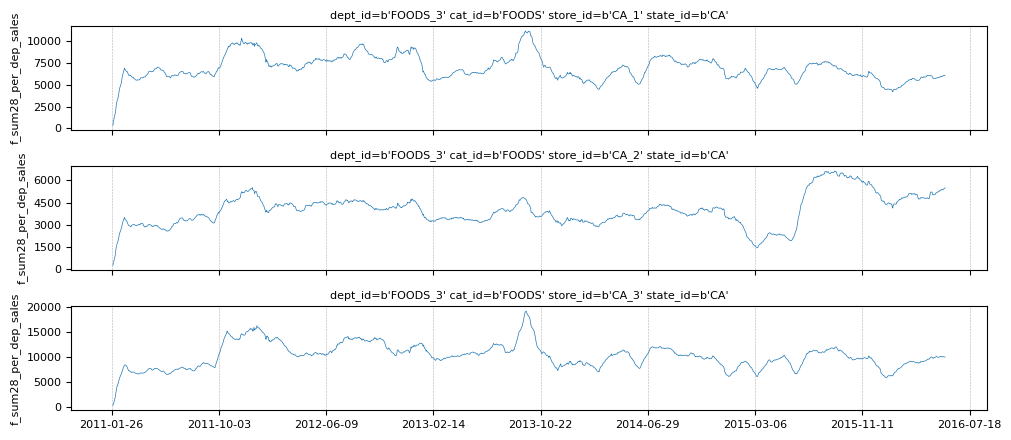

In [36]:
sum28_sales_per_dept.plot(max_num_plots=3, width_px=600)

The sales of each department is then _propagated_ back to each corresponding product.

Note that two products from the same department will receive the same features.


In [37]:
sum28_sales_per_dept = sum28_sales_per_dept.propagate(sales_evset, resample=True)

all_features.append(sum28_sales_per_dept)

The number of plots (80) is larger than "options.max_num_plots=3". Only the first plots will be printed.


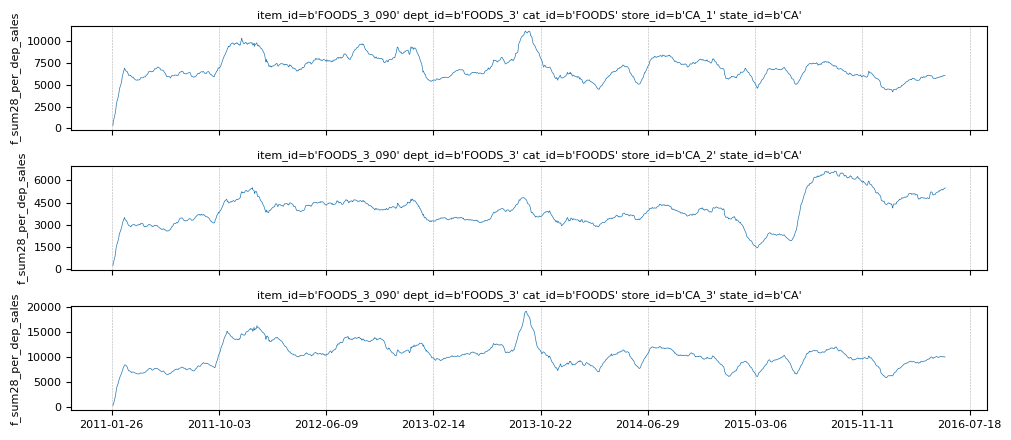

In [38]:
sum28_sales_per_dept.plot(max_num_plots=3, width_px=600)

### Special events

Special events such as holidays and sale periods can impact sales.


In [39]:
# Propagate the global special event to each product.
special_event_per_product = calendar_evset.propagate(sales_evset, resample=True)

# Since special events are known in advance, we can leak future special events in the past.
#
# For example, on 22/12/2016, the model can know that it will be christmas in 2 days.
special_events_list: List[tp.EventSet] = []
special_events_list.append(special_event_per_product.prefix("f_"))

for leak in [5]:
    x = special_event_per_product.leak(tp.duration.days(leak))
    x = x.resample(sales_evset)
    x = x.prefix(f"f_leak{leak}_")
    special_events_list.append(x)

# To make the model more powerful, we could also apply some moving statistics such
# as moving-maximum to create features such as: is it christmas in the following N days.

feature_special_events = tp.glue(*special_events_list)

all_features.append(feature_special_events)

In [40]:
feature_special_events.plot(**plot_options, max_num_plots=3)

The number of plots (14) is larger than "options.max_num_plots=3". Only the first plots will be printed.


### Review all the features

`all_features` contains all the features we want to feed to our model.
`tabular` is the data that will be used to train the model.


In [41]:
tabular = tp.glue(*all_features, sales_evset["day"], labels)

tabular.schema

features: [('f_sales', int64), ('f_sales_lag_1_d', int64), ('f_sales_lag_2_d', int64), ('f_sales_lag_3_d', int64), ('f_sales_lag_7_d', int64), ('f_sales_lag_14_d', int64), ('f_sma_7_sales', float32), ('f_sd_7_sales', float32), ('f_sum_7_sales', float32), ('f_sma_14_sales', float32), ('f_sd_14_sales', float32), ('f_sum_14_sales', float32), ('f_sma_28_sales', float32), ('f_sd_28_sales', float32), ('f_sum_28_sales', float32), ('f_sma_84_sales', float32), ('f_sd_84_sales', float32), ('f_sum_84_sales', float32), ('f_calendar_day_of_month', int32), ('f_calendar_day_of_week', int32), ('f_calendar_month', int32), ('f_sum28_per_dep_sales', int64), ('f_event_name_1', str_), ('f_event_type_1', str_), ('f_event_name_2', str_), ('f_event_type_2', str_), ('f_snap_CA', int64), ('f_snap_TX', int64), ('f_snap_WI', int64), ('f_leak5_event_name_1', str_), ('f_leak5_event_type_1', str_), ('f_leak5_event_name_2', str_), ('f_leak5_event_type_2', str_), ('f_leak5_snap_CA', int64), ('f_leak5_snap_TX', int64),

## Generate training and testing datasets

Compute all the new features and labels on the dataset.

The test dataset is the single day 1914. In this day, the model makes 28 predictions, one for each horizon, for each of the products.

For training, we use the data prior to the test day. We also remove the first 30 days as those days don't have enough data to compute good statistics.


In [42]:
tabular_test = tabular.filter(tp.equal_scalar(tabular["day"], 1914))
tabular_train = tabular.filter(
    (tabular["day"] >= 30) & (tabular["day"] < 1914)
)

Let's compute the test dataset.


In [43]:
test_dataset = tp.to_pandas(tabular_test)

test_dataset.head()

,item_id,dept_id,cat_id,store_id,state_id,f_sales,f_sales_lag_1_d,f_sales_lag_2_d,f_sales_lag_3_d,f_sales_lag_7_d,...,label_horizon_19_days,label_horizon_20_days,label_horizon_21_days,label_horizon_22_days,label_horizon_23_days,label_horizon_24_days,label_horizon_25_days,label_horizon_26_days,label_horizon_27_days,timestamp
0,FOODS_3_694,FOODS_3,FOODS,WI_2,WI,24,29,33,31,38,...,31,31,34,24,36,30,44,37,42,1.461542e+09
1,FOODS_3_694,FOODS_3,FOODS,WI_1,WI,13,24,28,18,27,...,10,27,20,20,16,22,31,30,32,1.461542e+09
2,FOODS_3_694,FOODS_3,FOODS,TX_3,TX,21,17,31,20,16,...,21,26,17,35,19,23,22,14,21,1.461542e+09
3,FOODS_3_694,FOODS_3,FOODS,TX_2,TX,26,21,17,22,9,...,26,33,12,19,13,11,18,38,25,1.461542e+09
4,FOODS_3_694,FOODS_3,FOODS,WI_3,WI,42,48,46,46,54,...,64,57,57,37,30,45,51,46,48,1.461542e+09


Let's compute the train dataset.


In [44]:
train_dataset = tp.to_pandas(tabular_train)

train_dataset.head()

,item_id,dept_id,cat_id,store_id,state_id,f_sales,f_sales_lag_1_d,f_sales_lag_2_d,f_sales_lag_3_d,f_sales_lag_7_d,...,label_horizon_19_days,label_horizon_20_days,label_horizon_21_days,label_horizon_22_days,label_horizon_23_days,label_horizon_24_days,label_horizon_25_days,label_horizon_26_days,label_horizon_27_days,timestamp
0,FOODS_3_694,FOODS_3,FOODS,WI_2,WI,48,47,31,46,38,...,34,32,29,32,18,24,41,30,44,1.298765e+09
1,FOODS_3_694,FOODS_3,FOODS,WI_2,WI,30,48,47,31,36,...,32,29,32,18,24,41,30,44,36,1.298851e+09
2,FOODS_3_694,FOODS_3,FOODS,WI_2,WI,42,30,48,47,29,...,29,32,18,24,41,30,44,36,15,1.298938e+09
3,FOODS_3_694,FOODS_3,FOODS,WI_2,WI,39,42,30,48,44,...,32,18,24,41,30,44,36,15,26,1.299024e+09
4,FOODS_3_694,FOODS_3,FOODS,WI_2,WI,25,39,42,30,46,...,18,24,41,30,44,36,15,26,33,1.299110e+09


We can convert those EventSets to Pandas DataFrames and save them to csv files for later use.


In [45]:
test_dataset.to_csv(os.path.join(work_directory, "test.csv"), index=False)
train_dataset.to_csv(os.path.join(work_directory, "train.csv"), index=False)

In [46]:
!head tmp/temporian_m5/train.csv -n 5

item_id,dept_id,cat_id,store_id,state_id,f_sales,f_sales_lag_1_d,f_sales_lag_2_d,f_sales_lag_3_d,f_sales_lag_7_d,f_sales_lag_14_d,f_sma_7_sales,f_sd_7_sales,f_sum_7_sales,f_sma_14_sales,f_sd_14_sales,f_sum_14_sales,f_sma_28_sales,f_sd_28_sales,f_sum_28_sales,f_sma_84_sales,f_sd_84_sales,f_sum_84_sales,f_calendar_day_of_month,f_calendar_day_of_week,f_calendar_month,f_sum28_per_dep_sales,f_event_name_1,f_event_type_1,f_event_name_2,f_event_type_2,f_snap_CA,f_snap_TX,f_snap_WI,f_leak5_event_name_1,f_leak5_event_type_1,f_leak5_event_name_2,f_leak5_event_type_2,f_leak5_snap_CA,f_leak5_snap_TX,f_leak5_snap_WI,day,label_horizon_1_days,label_horizon_2_days,label_horizon_3_days,label_horizon_4_days,label_horizon_5_days,label_horizon_6_days,label_horizon_7_days,label_horizon_8_days,label_horizon_9_days,label_horizon_10_days,label_horizon_11_days,label_horizon_12_days,label_horizon_13_days,label_horizon_14_days,label_horizon_15_days,label_horizon_16_days,label_horizon_17_days,label_horizon_18_day

### Training and evaluating a simple model

Now that we have pre-processed data, we can train a model. We will train a collection of Gradient Boosted Trees using TensorFlow Decision Forests.


In [47]:
%pip install tensorflow tensorflow_decision_forests -q

import tensorflow as tf
import tensorflow_decision_forests as tfdf


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


2023-08-22 17:19:07.938517: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 17:19:07.941786: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-22 17:19:08.021257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-22 17:19:08.022287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 17:19:09.593394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [48]:
# The name of the labels and features.
label_names = [x for x in test_dataset.columns if x.startswith("label_")]
feature_names = [x for x in test_dataset.columns if x.startswith("f_")] + [
    # The model also has access to the meta-data.
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
] 

print("label_names:", label_names)
print("feature_names:", feature_names)

label_names: ['label_horizon_1_days', 'label_horizon_2_days', 'label_horizon_3_days', 'label_horizon_4_days', 'label_horizon_5_days', 'label_horizon_6_days', 'label_horizon_7_days', 'label_horizon_8_days', 'label_horizon_9_days', 'label_horizon_10_days', 'label_horizon_11_days', 'label_horizon_12_days', 'label_horizon_13_days', 'label_horizon_14_days', 'label_horizon_15_days', 'label_horizon_16_days', 'label_horizon_17_days', 'label_horizon_18_days', 'label_horizon_19_days', 'label_horizon_20_days', 'label_horizon_21_days', 'label_horizon_22_days', 'label_horizon_23_days', 'label_horizon_24_days', 'label_horizon_25_days', 'label_horizon_26_days', 'label_horizon_27_days']
feature_names: ['f_sales', 'f_sales_lag_1_d', 'f_sales_lag_2_d', 'f_sales_lag_3_d', 'f_sales_lag_7_d', 'f_sales_lag_14_d', 'f_sma_7_sales', 'f_sd_7_sales', 'f_sum_7_sales', 'f_sma_14_sales', 'f_sd_14_sales', 'f_sum_14_sales', 'f_sma_28_sales', 'f_sd_28_sales', 'f_sum_28_sales', 'f_sma_84_sales', 'f_sd_84_sales', 'f_sum

The Pandas DataFrame can be converted into a TensorFlow dataset.


In [49]:
def dataset_pandas_to_tensorflow_dataset(df):
    features = {k: df[k] for k in feature_names}
    labels = {k: df[k] for k in label_names}
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(100)


tf_test_dataset = dataset_pandas_to_tensorflow_dataset(test_dataset)
tf_train_dataset = dataset_pandas_to_tensorflow_dataset(train_dataset)

We can train our model.


In [50]:
model_path = os.path.join(work_directory, "cache_model")
if os.path.exists(model_path):
    # Load the model if it was already trained.
    # If you change the dataset or the model parameters, change the "model_path". 
    # Note that loading the model won't display the training logs.
    model = tf.keras.models.load_model(model_path)
else:
    model = tfdf.keras.GradientBoostedTreesModel(
        multitask=[
            tfdf.keras.MultiTaskItem(x, task=tfdf.keras.Task.REGRESSION)
            for x in label_names
        ],
        num_trees=40,  # Increase the number of trees (e.g., 100) for a better model.
        verbose=2, # Remove to make the training less verbose.
    )
    model.fit(tf_train_dataset)

Use /tmp/tmpfn9n19rs as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'f_sales': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'f_sales_lag_1_d': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'f_sales_lag_2_d': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'f_sales_lag_3_d': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'f_sales_lag_7_d': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'f_sales_lag_14_d': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'f_sma_7_sales': <tf.Tensor 'data_6:0' shape=(None,) dtype=float32>, 'f_sd_7_sales': <tf.Tensor 'data_7:0' shape=(None,) dtype=float32>, 'f_sum_7_sales': <tf.Tensor 'data_8:0' shape=(None,) dtype=float32>, 'f_sma_14_sales': <tf.Tensor 'data_9:0' shape=(None,) dtype=float32>, 'f_sd_14_sales': <tf.Tensor 'data_10:0' shape=(None,) dtype=float32>, 'f_sum_14_sales': <tf.Tensor 'data_11:0' shape=(None,) dtype=float32>, 'f_sma_28_sales': <tf.Tensor 'data_12:0' shape=(None,) dtype

[INFO 23-08-22 17:19:27.7980 CEST kernel.cc:773] Start Yggdrasil model training
[INFO 23-08-22 17:19:27.7980 CEST kernel.cc:774] Collect training examples
[INFO 23-08-22 17:19:27.7981 CEST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^label_horizon_1_days$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^label_horizon_2_days$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^label_horizon_3_days$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^label_horizon_4_days$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^label_horizon_5_days$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^label_horizon_6_days$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^label_horizon_7_days$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^label_horizon_8_days$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^label_horizon_9_days$"
  type: NUMERICAL
}
column_guides {
  column

Model trained in 0:07:19.827763
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


Let's generate the predictions on the test dataset.


In [51]:
tf_predictions = model.predict(tf_test_dataset, verbose=0)

Let's convert those TensorFlow predictions into a Temporian EventSet. This way we will be able to plot the predictions alongside the real sales.


In [52]:
index_names = tabular_test.schema.index_names()

raw_predicted_sales = defaultdict(list)
timestamps = []

# For each product
for row_idx in range(len(test_dataset)):
    original_timestamp = datetime.fromtimestamp(
        test_dataset["timestamp"][row_idx], tz=timezone.utc
    )

    # For each prediction horizon
    for horizon, predictions in zip(horizons, tf_predictions.values()):
        timestamps.append(original_timestamp + timedelta(days=horizon))

        for k in index_names:
            raw_predicted_sales[k].append(test_dataset[k][row_idx])

        raw_predicted_sales["prediction_sales"].append(predictions[row_idx, 0])

# Convert the dictionary of values into an event set.
prediction_evset = tp.event_set(
    timestamps, raw_predicted_sales, indexes=index_names
)

Finally, we can plot the real sales and predicted sales.

**Remember:** Update the variable `horizons` to change the number of days the model is predicting (14 by default).

### Plot predictions

Let's now show some predictions and compare them against the real sales. The sales before the test day 1914 are considered past sales, and then we compare the predictions against real sales after the test day.

In this cell we'll just use the standard plots, and then we'll customize them to better compare predictions against ground-truth.

The number of plots (80) is larger than "options.max_num_plots=6". Only the first plots will be printed.


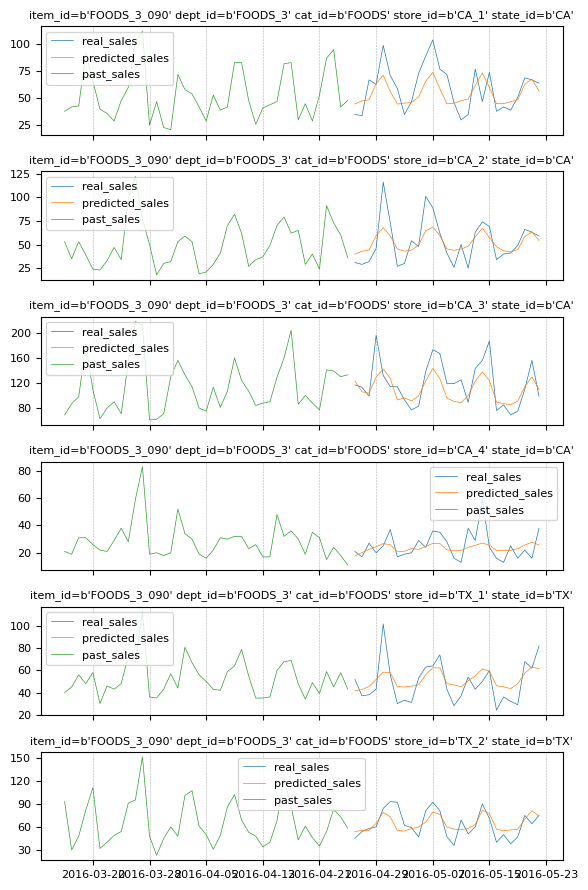

In [55]:
real_sales_evset = sales_evset["sales"].filter(sales_evset["day"] > 1914)

past_sales_evset = sales_evset["sales"].filter((sales_evset["day"] <= 1914) & (sales_evset["day"] >= 1914 - 40))

# Rename and plot together
real_sales_evset = real_sales_evset.rename("real_sales")
past_sales_evset = past_sales_evset.rename("past_sales")
prediction_evset = prediction_evset.rename("predicted_sales")

tp.plot(
    [real_sales_evset, prediction_evset, past_sales_evset],
    max_num_plots=3*2,
    width_px=600,
    merge=True,
)


How does that model work? We can look at the variable importance to get an idea of what feature matters the most with `model.summary()`.

Note that this model contains in fact one individual model for each horizon. In other words, this model contains 28 sub models!